In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import gc

csv to parquet()

-> 메모리에 효율적인 데이터 유형을 사용하여 용량을 크게 줄이고 빠른 작업이 가능

In [ ]:
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done.')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


컬럼 설명

In [ ]:
col=pd.read_csv('./data_info.csv')
col

,변수명,변수 설명
0,id,아이디
1,base_date,날짜
2,day_of_week,요일
3,base_hour,시간대
4,road_in_use,도로사용여부
5,lane_count,차로수
6,road_rating,도로등급
7,multi_linked,중용구간 여부
8,connect_code,연결로 코드
9,maximum_speed_limit,최고속도제한


In [ ]:
csv_to_parquet('./train.csv', 'train')
csv_to_parquet('./test.csv', 'test')

train Done.
test Done.


In [ ]:
train = pd.read_parquet('./train.parquet')
test = pd.read_parquet('./test.parquet')

데이터 타입 및 결측값 개수 확인

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   base_date              int64  
 2   day_of_week            object 
 3   base_hour              int64  
 4   lane_count             int64  
 5   road_rating            int64  
 6   road_name              object 
 7   multi_linked           int64  
 8   connect_code           int64  
 9   maximum_speed_limit    float64
 10  vehicle_restricted     float64
 11  weight_restricted      float64
 12  height_restricted      float64
 13  road_type              int64  
 14  start_node_name        object 
 15  start_latitude         float64
 16  start_longitude        float64
 17  start_turn_restricted  object 
 18  end_node_name          object 
 19  end_latitude           float64
 20  end_longitude          float64
 21  end_turn_restricted    object 
 22  target            

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291241 entries, 0 to 291240
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     291241 non-null  object 
 1   base_date              291241 non-null  int64  
 2   day_of_week            291241 non-null  object 
 3   base_hour              291241 non-null  int64  
 4   lane_count             291241 non-null  int64  
 5   road_rating            291241 non-null  int64  
 6   road_name              291241 non-null  object 
 7   multi_linked           291241 non-null  int64  
 8   connect_code           291241 non-null  int64  
 9   maximum_speed_limit    291241 non-null  float64
 10  vehicle_restricted     291241 non-null  float64
 11  weight_restricted      291241 non-null  float64
 12  height_restricted      291241 non-null  float64
 13  road_type              291241 non-null  int64  
 14  start_node_name        291241 non-nu

In [ ]:
train.isnull().sum()

id                       0
base_date                0
day_of_week              0
base_hour                0
lane_count               0
road_rating              0
road_name                0
multi_linked             0
connect_code             0
maximum_speed_limit      0
vehicle_restricted       0
weight_restricted        0
height_restricted        0
road_type                0
start_node_name          0
start_latitude           0
start_longitude          0
start_turn_restricted    0
end_node_name            0
end_latitude             0
end_longitude            0
end_turn_restricted      0
target                   0
dtype: int64

In [ ]:
test.isnull().sum()

id                       0
base_date                0
day_of_week              0
base_hour                0
lane_count               0
road_rating              0
road_name                0
multi_linked             0
connect_code             0
maximum_speed_limit      0
vehicle_restricted       0
weight_restricted        0
height_restricted        0
road_type                0
start_node_name          0
start_latitude           0
start_longitude          0
start_turn_restricted    0
end_node_name            0
end_latitude             0
end_longitude            0
end_turn_restricted      0
dtype: int64

# 전처리

데이터프레임의 용량이 크기 때문에 자료형을 변형해주지 않으면 램 용량을 초과하여 학습을 하지 못할 수도 있습니다.

In [ ]:
# 1차 자료형 변형
to_int32 = ["base_date", "base_hour", "lane_count", "road_rating", "multi_linked", "connect_code", "road_type"]
to_float32 = ["vehicle_restricted", "height_restricted", "maximum_speed_limit", "weight_restricted", "target"]

for i in to_int32:
    train[i] = train[i].astype("int32")
for j in to_float32:
    train[j] = train[j].astype("float32")

한 가지 값만 존재하는 컬럼 찾기

In [ ]:
only_one_value = []
for i in train.columns[2:]:
    if len(train[i].value_counts()) <2:
        only_one_value.append(i)
len(only_one_value)

only_one_value

In [ ]:
# 한가지 값만 존재하는 컬럼 삭제
train.drop(["vehicle_restricted", "height_restricted"], axis = 1, inplace = True)
test.drop(["vehicle_restricted", "height_restricted"], axis = 1, inplace = True)

In [ ]:
train['vehicle_restricted'].unique()

array([0.])

In [ ]:
train['height_restricted'].unique()

array([0.])

상관관계

: 최고속도 제한(maximum_speed_limit)이 높을 수록 양의 상관관계가 있다는 것을 알 수 있음

weight_restricted(통과 제한 하중)은 target과의 양의 상관관계

lane_count(차로 수)는 많을수록 속도가 더 높을 것 같음에도 target과의 음의 상관관계


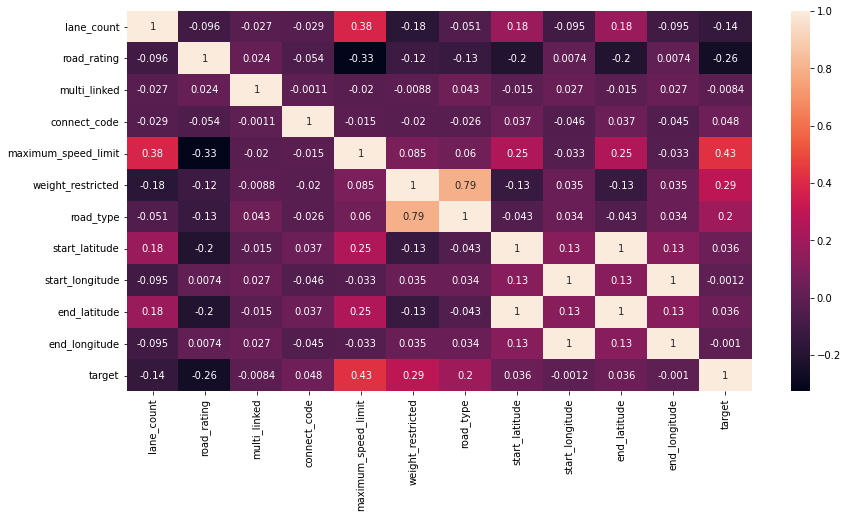

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# "base_date"와 "base_hour"는 상관관계를 분석하지 않을 것이기에 임시로 object로 변형
train[["base_date", "base_hour"]] = train[["base_date", "base_hour"]].astype(object)
plt.figure(figsize = (14,7))
sns.heatmap(train.corr(), annot = True)

# object로 변형하였던 "base_hour", "base_date"를 다시 int형으로 변형
train[["base_hour", "base_date"]] = train[["base_hour","base_date"]].astype("int32")

최고 제한 속도

극단치와 값차이가 많이 나므로 제거

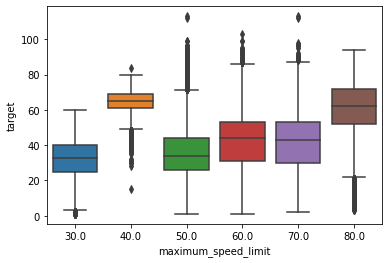

In [ ]:
sns.boxplot(x = "maximum_speed_limit", y = "target", data = train)

도로 등급(road_rating)

106 : 지방도

103 : 일반국도

107 : 시도-군도

평균적으로는 도로등급이 106, 103일 때 높은 속도를 보이며 107은 앞의 두 특성과 비교했을 때 평균 차이 발생

최댓값에서도 도로등급 107이 가장 낮은 속도

In [ ]:
train['road_rating'].unique()

array([106, 103, 107], dtype=int32)

In [ ]:
train.road_rating.value_counts()

103    2159511
107    1582214
106     959492
Name: road_rating, dtype: int64

In [ ]:
print(train.groupby("road_rating")["target"].mean())
print(train.groupby("road_rating")["target"].max())

road_rating
103    46.388466
106    48.021549
107    34.701408
Name: target, dtype: float32
road_rating
103    113.0
106     99.0
107     94.0
Name: target, dtype: float32


target 값 속도 100km/h 이상 제거

속도 EDA부분을 봤을 때 최고 제한속도가 80km/h이기 때문에 차이가 심하게나는 극단치(100km/h 이상)만을 제거

In [ ]:
train = train[train.target<100]

start_node_name과 end_node_name을 key값으로 만들기

In [ ]:
train['node_combination'] = train['start_node_name'] + '_' + train['end_node_name']
test['node_combination'] = test['start_node_name'] + '_' + test['end_node_name']

LabelEncoder

: 카테고리형 데이터를 수치형으로 변환

(OneHotEncoder 사용하려 했지만, RAM 초과로 실행 안 됨)

In [ ]:
str_col = ['day_of_week','start_turn_restricted','end_turn_restricted','node_combination']
for i in str_col:
    le = LabelEncoder()
    le=le.fit(train[i])
    train[i]=le.transform(train[i])

    for label in np.unique(test[i]):
        if label not in le.classes_:
            le.classes_ = np.append(le.classes_, label)
    test[i]=le.transform(test[i])

In [ ]:
str_col = ['road_name']
for i in str_col:
    le = LabelEncoder()
    le=le.fit(train[i])
    train[i]=le.transform(train[i])

    for label in np.unique(test[i]):
        if label not in le.classes_:
            le.classes_ = np.append(le.classes_, label)
    test[i]=le.transform(test[i])

불필요한 columm 삭제

In [ ]:
y_train = train['target']

X_train = train.drop(['id','base_date', 'target','road_name', 'start_node_name', 'end_node_name'], axis=1)

test = test.drop(['id','base_date', 'road_name', 'start_node_name', 'end_node_name'], axis=1)

### 모델 선언 및 학습

kFold 사용해서 train과 Validation 나눠주기

RandomForestRegressor, ExtraTreesRegressor, LGBMRegressor, XGBRegressor, CatBoostRegressor 모델 사용하여 스태킹 해주기

In [ ]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [ ]:
from sklearn.model_selection import StratifiedKFold as kfold
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error

# 연속적인 값인 만큼 stratify kfold 를 사용할 수 없지만 나누는 것은 kfold와 동일합니다.
kf = kfold(n_splits = 5, shuffle = True, random_state = 42)
split = kf.split(X_train, Y_train)

# 평균 mae를 확인하기 위한 리스트
mae_list1 = []
mae_list2 = []
mae_list3 = []
mae_list4 = []

# 폴드별 예측값 저장을 위한 리스트
test_pred_list1 = []
test_pred_list2 = []
test_pred_list3 = []
test_pred_list4 = []

for train, test in split:
    x_train, x_val, y_train, y_val = X_train.iloc[train], X_train.iloc[test], Y_train.iloc[train], Y_train.iloc[test]

    rf = RandomForestRegressor()
    et = ExtraTreesRegressor()
    lgb = LGBMRegressor()
    xgb = XGBRegressor()
    cb = CatBoostRegressor()


    rf.fit(x_train, y_train)
    et.fit(x_train, y_train)
    lgb.fit(x_train, y_train)
    xgb.fit(x_train, y_train)


    pred1 = rf.predict(x_val)
    pred2 = et.predict(x_val)
    pred3 = lgb.predict(x_val)
    pred4 = xgb.predict(x_val)


    result1 = mean_absolute_error(pred1,y_val)
    result2 = mean_absolute_error(pred2,y_val)
    result3 = mean_absolute_error(pred3,y_val)
    result4 = mean_absolute_error(pred4,y_val)

    mae_list1.append(result1)
    mae_list2.append(result2)
    mae_list3.append(result3)
    mae_list4.append(result4)

    print(f'RandomForestRegressor mae : {result1:.4f}', end='\n\n')
    print(f'ExtraTreeRegressor mae : {result2:.4f}', end='\n\n')
    print(f'LGBMRegressor mae : {result3:.4f}', end='\n\n')
    print(f'XGBRegressor mae : {result4:.4f}', end='\n\n')

    test_pred_list1.append(rf.predict(X_test))
    test_pred_list2.append(et.predict(X_test))
    test_pred_list3.append(lgb.predict(X_test))
    test_pred_list4.append(xgb.predict(X_test))

print(f'mean mae {np.mean(mae_list1):.4f}')
print(f'mean mae {np.mean(mae_list2):.4f}')
print(f'mean mae {np.mean(mae_list3):.4f}')
print(f'mean mae {np.mean(mae_list4):.4f}')

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[01:30:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RandomForestRegressor mae : 3.5552

ExtraTreeRegressor mae : 3.5553

LGBMRegressor mae : 4.7319

XGBRegressor mae : 6.5504

[02:47:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RandomForestRegressor mae : 3.5501

ExtraTreeRegressor mae : 3.5502

LGBMRegressor mae : 4.6939

XGBRegressor mae : 6.5475

[04:06:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RandomForestRegressor mae : 3.5494

ExtraTreeRegressor mae : 3.5498

LGBMRegressor mae : 4.7331

XGBRegressor mae : 6.5291

[05:22:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RandomForestRegressor mae : 3.5526

ExtraTreeRegressor mae : 3.5532

LGBMRegressor mae : 4.7297

XGBRegressor mae : 6.51

In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [ ]:
from catboost import CatBoostRegressor, Pool

mae_list5 = []
test_pred_list5 = []


cb = CatBoostRegressor()
cb.fit(x_train, y_train, early_stopping_rounds = 8)
pred5 = cb.predict(x_val)

result5 = mean_absolute_error(pred5,y_val)
mae_list5.append(result5)
print(f'CatBoostRegressor mae : {result5:.4f}', end='\n\n')
test_pred_list5.append(cb.predict(X_test))
print(f'mean mae {np.mean(mae_list5):.4f}')

Learning rate set to 0.150341
0:	learn: 14.6594447	total: 1.48s	remaining: 24m 39s
1:	learn: 13.6368149	total: 2.09s	remaining: 17m 22s
2:	learn: 12.8176318	total: 2.68s	remaining: 14m 49s
3:	learn: 12.1759293	total: 3.24s	remaining: 13m 27s
4:	learn: 11.6258418	total: 3.82s	remaining: 12m 40s
5:	learn: 11.2089873	total: 4.38s	remaining: 12m 6s
6:	learn: 10.8544995	total: 4.96s	remaining: 11m 43s
7:	learn: 10.5909907	total: 5.51s	remaining: 11m 23s
8:	learn: 10.3315219	total: 6.09s	remaining: 11m 11s
9:	learn: 10.0860456	total: 6.68s	remaining: 11m 1s
10:	learn: 9.9299133	total: 7.24s	remaining: 10m 50s
11:	learn: 9.7574783	total: 7.83s	remaining: 10m 44s
12:	learn: 9.6058199	total: 8.39s	remaining: 10m 37s
13:	learn: 9.4637828	total: 8.94s	remaining: 10m 29s
14:	learn: 9.3651507	total: 9.52s	remaining: 10m 24s
15:	learn: 9.2459046	total: 10.1s	remaining: 10m 20s
16:	learn: 9.1583905	total: 10.7s	remaining: 10m 16s
17:	learn: 9.0781132	total: 11.2s	remaining: 10m 12s
18:	learn: 9.00351

In [ ]:
# 스태킹을 위해 pred_last에 할당합니다.
pred_last1 = (test_pred_list1[0] + test_pred_list1[1] + test_pred_list1[2])/3
pred_last2 = (test_pred_list2[0] + test_pred_list2[1] + test_pred_list2[2])/3
pred_last3 = (test_pred_list3[0] + test_pred_list3[1] + test_pred_list3[2])/3
pred_last4 = (test_pred_list4[0] + test_pred_list4[1] + test_pred_list4[2])/3
pred_last5 = (test_pred_list5[0] + test_pred_list5[1] + test_pred_list5[2])/3

# 스태킹 한 두 값을 평균내어 최종 결과를 도출합니다.
pred_last = (pred_last1 + pred_last2 + pred_last3 + pred_last4 + pred_last5) / 5

# RandomForestRegressor(), ExtraTreesRegressor()을 스태킹 한 것이 가장 결과가 좋음

In [ ]:
pred_last_2 = (pred_last1 + pred_last2 ) / 2